In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
from datetime import datetime
import pytz
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Pandas 1.3.4
Scikit-Learn 1.0
GPU is available


In [2]:
resnet152_input_shape = (224, 224)
inceptionV3_input_shape = (299, 299)
batch_size = 1
print(os.getcwd())
chb01_path = "../windows/train"
labels = [item for item in os.listdir(chb01_path)]
labels = np.array(labels)
labels = labels[0:]
print(labels.shape)
labels

c:\Users\45535\Desktop\speciale\DeepLearning_Master\Single_channel_models
(4,)


array(['Interictal', 'Preictal_One', 'Preictal_Two', 'Seizure'],
      dtype='<U12')

In [3]:
from tensorflow.keras.applications import ResNet152, InceptionV3, InceptionResNetV2

In [4]:
inceptionV3 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape = (299, 299, 3)
)

for layer in inceptionV3.layers:
    layer.trainable = True

In [5]:
inceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [6]:
resnet152 = ResNet152(
    weights='imagenet',
    include_top=False,
    input_shape=((224, 224, 3))
)

for layer in resnet152.layers:
    layer.trainable = True

reshaping = layers.Reshape((8, 8, 1568))(resnet152.output)
re_config_resnet152 = tensorflow.keras.Model(inputs=resnet152.input, outputs=reshaping)

In [7]:
a = np.zeros(shape=(7, 7, 2048))
a = a.reshape(8, 8, 1568)
a.shape

(8, 8, 1568)

In [8]:
re_config_resnet152.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:

# sort losses of batch descending order
# the largest k? is averaged as the final loss
# return loss
# parameters needed: SUM, label(i), loss of batches


def ohem_loss(ytrue, ypred):
    result = K.categorical_crossentropy(ytrue, ypred, axis=-1)
    alpha = K.variable(0.1, dtype=tf.float32)
    index = K.greater(result, alpha)
    cast = tf.cast(index, tf.float32)
    return result*cast

In [10]:
from tensorflow.keras import Model
from tensorflow.keras import backend as K


concat_feature_layer = layers.concatenate([inceptionV3.output, re_config_resnet152.output])
fully_connected_dense_big = layers.Dense(1024, activation='relu')(concat_feature_layer)
dropout_one = layers.Dropout(0.5)(fully_connected_dense_big)
flatten_layer = layers.Flatten()(dropout_one)
fully_connected_dense_small = layers.Dense(512, activation='relu')(flatten_layer)
dropout_two = layers.Dropout(0.5)(fully_connected_dense_small)
fully_connected_dense_class = layers.Dense(4, activation='softmax')(dropout_two)

model = Model(
    inputs=[inceptionV3.input, re_config_resnet152.input],
    outputs=fully_connected_dense_class
)

model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [11]:
modelplot = tensorflow.keras.utils.plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [2]:
print(os.getcwd())
chb01_path = "../windows/train"

c:\Users\45535\Desktop\speciale\DeepLearning_Master\Single_channel_models


In [4]:
resnet152_input_shape = (224, 224)
inceptionV3_input_shape = (299, 299)
batch_size = 1

In [5]:
labels = [item for item in os.listdir(chb01_path)]
labels = np.array(labels)
labels = labels[0:]
print(labels.shape)
labels

(4,)


array(['Interictal', 'Preictal_One', 'Preictal_Two', 'Seizure'],
      dtype='<U12')

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
len([f for f in os.listdir(chb01_path + "/Seizure")]) * 0.2

43.800000000000004

In [3]:
generator = ImageDataGenerator(
  rescale=1./255,
  validation_split=0.2
)

In [4]:
resnet_train_gen = generator.flow_from_directory(directory=chb01_path,batch_size=batch_size, target_size=resnet152_input_shape, classes=list(labels), subset="training")
resnet_test_gen = generator.flow_from_directory(directory=chb01_path,batch_size=batch_size, target_size=resnet152_input_shape, classes=list(labels), subset="validation")

Found 17999 images belonging to 4 classes.
Found 4498 images belonging to 4 classes.


In [4]:
inception_train_gen = generator.flow_from_directory(directory=chb01_path,batch_size=batch_size, target_size=inceptionV3_input_shape, classes=list(labels), subset="training")
inception_test_gen = generator.flow_from_directory(directory=chb01_path,batch_size=batch_size, target_size=inceptionV3_input_shape, classes=list(labels), subset="validation", shuffle=False)

Found 17999 images belonging to 4 classes.
Found 4498 images belonging to 4 classes.


In [22]:
type(incep_data_list)

incep_data_list = np.array(incep_data_list)

In [6]:
list_of_files = []
count = 0

int_count = 0
sz_count = 0
prei1 = 0
prei2 = 0

for i in inception_test_gen:
    idx = (inception_test_gen.batch_index - 1) * inception_test_gen.batch_size
    x = str(inception_test_gen.filenames[idx : idx + inception_test_gen.batch_size])
    

    if "Interictal" in x and int_count <= 40:
      list_of_files.append(["../windows/train/" + str(inception_test_gen.filenames[idx : idx + inception_test_gen.batch_size]).replace("]", "").replace("[", "").replace("'", "").replace("\\\\", "/"), "Interictal"])
      int_count += 1
      print(f"int: {int_count}")

    if "Preictal_One" in x and prei1 <= 40:
      list_of_files.append(["../windows/train/" + str(inception_test_gen.filenames[idx : idx + inception_test_gen.batch_size]).replace("]", "").replace("[", "").replace("'", "").replace("\\\\", "/"), "Preictal_One"])
      prei1 += 1

    if "Preictal_Two" in x and prei2 <= 40:
      list_of_files.append(["../windows/train/" + str(inception_test_gen.filenames[idx : idx + inception_test_gen.batch_size]).replace("]", "").replace("[", "").replace("'", "").replace("\\\\", "/"), "Preictal_Two"])
      prei2 += 1
      print(f"prei2: {prei2}")

    if "Seizure" in x and sz_count <= 40:
      list_of_files.append(["../windows/train/" + str(inception_test_gen.filenames[idx : idx + inception_test_gen.batch_size]).replace("]", "").replace("[", "").replace("'", "").replace("\\\\", "/"), "Seizure"])
      sz_count += 1
      print(f"sz: {sz_count}")


    if prei1 >= 40 and prei2 >= 40 and sz_count >= 40 and int_count >= 40:
      test_df = pd.DataFrame(list_of_files, columns=['filename', 'class'])
      test_df.to_csv('tester.csv')
      break

int: 1
int: 2
int: 3
int: 4
int: 5
int: 6
int: 7
int: 8
int: 9
int: 10
int: 11
int: 12
int: 13
int: 14
int: 15
int: 16
int: 17
int: 18
int: 19
int: 20
int: 21
int: 22
int: 23
int: 24
int: 25
int: 26
int: 27
int: 28
int: 29
int: 30
int: 31
int: 32
int: 33
int: 34
int: 35
int: 36
int: 37
int: 38
int: 39
int: 40
int: 41
prei2: 1
prei2: 2
prei2: 3
prei2: 4
prei2: 5
prei2: 6
prei2: 7
prei2: 8
prei2: 9
prei2: 10
prei2: 11
prei2: 12
prei2: 13
prei2: 14
prei2: 15
prei2: 16
prei2: 17
prei2: 18
prei2: 19
prei2: 20
prei2: 21
prei2: 22
prei2: 23
prei2: 24
prei2: 25
prei2: 26
prei2: 27
prei2: 28
prei2: 29
prei2: 30
prei2: 31
prei2: 32
prei2: 33
prei2: 34
prei2: 35
prei2: 36
prei2: 37
prei2: 38
prei2: 39
prei2: 40
prei2: 41
sz: 1
sz: 2
sz: 3
sz: 4
sz: 5
sz: 6
sz: 7
sz: 8
sz: 9
sz: 10
sz: 11
sz: 12
sz: 13
sz: 14
sz: 15
sz: 16
sz: 17
sz: 18
sz: 19
sz: 20
sz: 21
sz: 22
sz: 23
sz: 24
sz: 25
sz: 26
sz: 27
sz: 28
sz: 29
sz: 30
sz: 31
sz: 32
sz: 33
sz: 34
sz: 35
sz: 36
sz: 37
sz: 38
sz: 39
sz: 40


In [5]:
test_df = pd.read_csv("tester.csv")

In [6]:
inc_test_gen = generator.flow_from_dataframe(test_df,batch_size=batch_size, target_size=inceptionV3_input_shape, classes=list(labels), shuffle=False)

Found 163 validated image filenames belonging to 4 classes.


In [7]:
res_test_gen = generator.flow_from_dataframe(test_df,batch_size=batch_size, target_size=resnet152_input_shape, classes=list(labels), shuffle=False)

Found 163 validated image filenames belonging to 4 classes.


In [8]:
def generator_test():
     while True:
        X1i = inc_test_gen.next()
        X2i = res_test_gen.next()
        yield [X1i[0], X2i[0]], X1i[1]

In [20]:
def show_batch(image, label):
  plt.figure(figsize=(10,10))
  for n in range(batch_size):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image[n])
      plt.title(labels[label[n].argmax()])
      plt.axis('off')

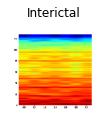

In [21]:
image, label = next(resnet_train_gen)
show_batch(image, label)

In [22]:
# history = model.fit(
#     x=generator_train(),
#     epochs=10,
#     batch_size=batch_size,
#     steps_per_epoch = inception_train_gen.samples//batch_size
# )

In [23]:
model.save("h5_files/ten_epoch_onlytrain_model")

INFO:tensorflow:Assets written to: h5_files/ten_epoch_onlytrain_model\assets


C:\Users\45535\AppData\Roaming\Python\Python38\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Evaluate

In [9]:
model = tf.keras.models.load_model("../Single_channel_models/h5_files/ten_epoch_onlytrain_model.h5")


In [10]:
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

In [11]:
y_true = inc_test_gen.classes
y_true

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

In [12]:
number_of_steps = inc_test_gen.samples // batch_size
number_of_steps

163

In [13]:
y_pred = model.predict(generator_test(), number_of_steps)

KeyboardInterrupt: 

In [ ]:
y_pred_max = y_pred.armax(axis=-1)

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix

In [ ]:
clf_report = classification_report(y_true=y_true, y_pred=y_pred_max, target_names=labels)

In [ ]:
print(clf_report)

In [ ]:
confusion_matrix = confusion_matrix(y_true=y_true, y_pred=list(y_pred_max))

confusion_matrix

In [ ]:
import matplotlib

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels_as_array).plot(cmap='Blues')
plt.title("10 Epoch : chb01=train : chb01valida=test")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig("hi2.png")